In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder,RareLabelEncoder

In [40]:
data=pd.read_csv("titanic.csv",usecols=["Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Embarked","Survived"])
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


In [41]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [42]:
data.nunique()

Survived      2
Pclass        3
Sex           2
Age          88
SibSp         7
Parch         7
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [43]:
nunique = pd.DataFrame(data.nunique())
nunique.style.background_gradient(cmap="turbo")

,0
Survived,2
Pclass,3
Sex,2
Age,88
SibSp,7
Parch,7
Fare,248
Cabin,147
Embarked,3


In [44]:
X = data.drop("Survived",axis=1)
y = data["Survived"]

In [45]:
y.nunique()

2

In [46]:
cat_cols = list(X.select_dtypes(exclude="number"))
num_cols = list(X.select_dtypes(include="number"))
num_but_cat = [col for col in num_cols if X[col].nunique()<10]
cat_but_car = [col for col in cat_cols if X[col].nunique()>20]

cat_cols = cat_cols + num_but_cat

cat_cols = [col for col in cat_cols if col not in cat_but_car]
num_cols = [col for col in num_cols if col not in num_but_cat]

In [47]:
data[cat_cols]

,Sex,Embarked,Pclass,SibSp,Parch
0,male,S,3,1,0
1,female,C,1,1,0
2,female,S,3,0,0
3,female,S,1,1,0
4,male,S,3,0,0
...,...,...,...,...,...
886,male,S,2,0,0
887,female,S,1,0,0
888,female,S,3,1,2
889,male,C,1,0,0


In [48]:
data[cat_but_car]

,Cabin
0,NaN
1,C85
2,NaN
3,C123
4,NaN
...,...
886,NaN
887,B42
888,NaN
889,C148


In [49]:
data[num_cols]

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
...,...,...
886,27.0,13.0000
887,19.0,30.0000
888,NaN,23.4500
889,26.0,30.0000


In [50]:
# data[num_cols].boxplot(figsize=(12,6))

In [51]:
# data[num_but_cat].boxplot(figsize=(12,6),color='black')

In [52]:
data["Parch"].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [53]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [54]:
data["Cabin_num"] = data["Cabin"].str.extract('(\d+)')
data["Cabin_num"] = data["Cabin_num"].astype(float)
data["Cabin_cat"] = data["Cabin"].str[0]
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_num,Cabin_cat
0,0,3,male,22.0,1,0,7.2500,NaN,S,NaN,NaN
1,1,1,female,38.0,1,0,71.2833,C85,C,85.0,C
2,1,3,female,26.0,0,0,7.9250,NaN,S,NaN,NaN
3,1,1,female,35.0,1,0,53.1000,C123,S,123.0,C
4,0,3,male,35.0,0,0,8.0500,NaN,S,NaN,NaN


In [55]:
data.drop("Cabin",axis=1,inplace=True)

In [56]:
X_train,X_test,y_train,y_test = train_test_split(data.drop("Survived",axis=1),data["Survived"],test_size=0.15,random_state=10,stratify=data["Survived"])
X_train.shape,X_test.shape

((757, 9), (134, 9))

In [57]:
X_train.isnull().mean()

Pclass       0.000000
Sex          0.000000
Age          0.194188
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.002642
Cabin_num    0.782034
Cabin_cat    0.778071
dtype: float64

In [58]:
X_train["Cabin_cat"].value_counts(normalize=True)

Cabin_cat
C    0.279762
B    0.220238
D    0.172619
E    0.160714
A    0.083333
F    0.059524
G    0.017857
T    0.005952
Name: proportion, dtype: float64

array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Cabin_num'}>]], dtype=object)

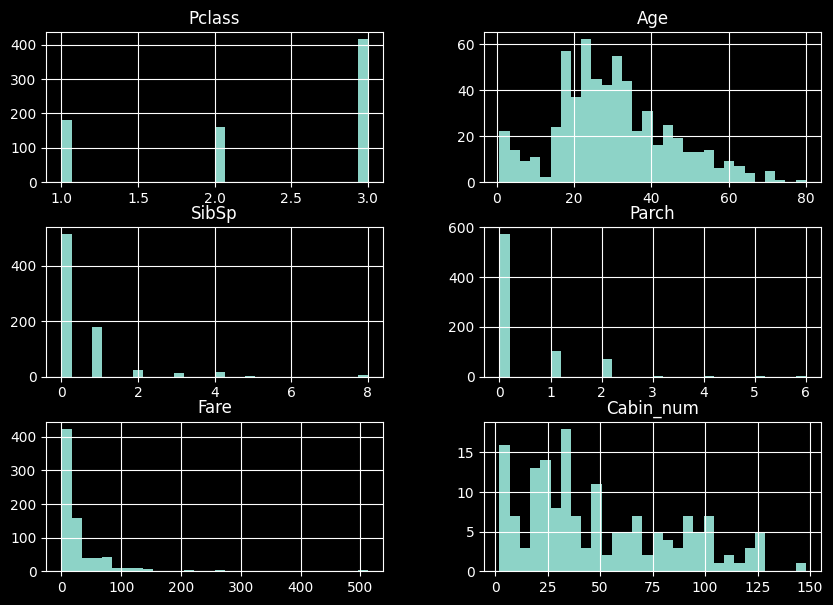

In [59]:
X_train.select_dtypes(include="number").hist(bins=30,figsize=(10,7))

In [60]:
data.isnull().sum()

Survived       0
Pclass         0
Sex            0
Age          177
SibSp          0
Parch          0
Fare           0
Embarked       2
Cabin_num    691
Cabin_cat    687
dtype: int64

In [61]:
from feature_engine.imputation import ArbitraryNumberImputer

In [62]:
titanic_pipe = Pipeline(steps=[
    ("imputer_num",ArbitraryNumberImputer(arbitrary_number=-1,
                                          variables=["Age","Fare","Cabin_num"])),
    ("imputer_cat",CategoricalImputer(variables=["Embarked","Cabin_cat"])),
    ("rare_encoder",RareLabelEncoder(tol=0.05,n_categories=2,variables=["Cabin_cat"])),
    ("categorical_encoder",OrdinalEncoder(encoding_method="ordered",
                                          variables=["Cabin_cat","Sex","Embarked"])),
    ("gbm",GradientBoostingClassifier(random_state=0))
])

In [64]:
from sklearn.model_selection import cross_val_score
cross_val_score(titanic_pipe,X_train,y_train,cv=10,scoring="roc_auc",n_jobs=-1).mean()

0.8508069103745999

In [65]:
titanic_pipe.fit(X_train,y_train)

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['Age', 'Fare',
                                                   'Cabin_num'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'Cabin_cat'])),
                ('rare_encoder',
                 RareLabelEncoder(n_categories=2, variables=['Cabin_cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Cabin_cat', 'Sex', 'Embarked'])),
                ('gbm', GradientBoostingClassifier(random_state=0))])

<Axes: >

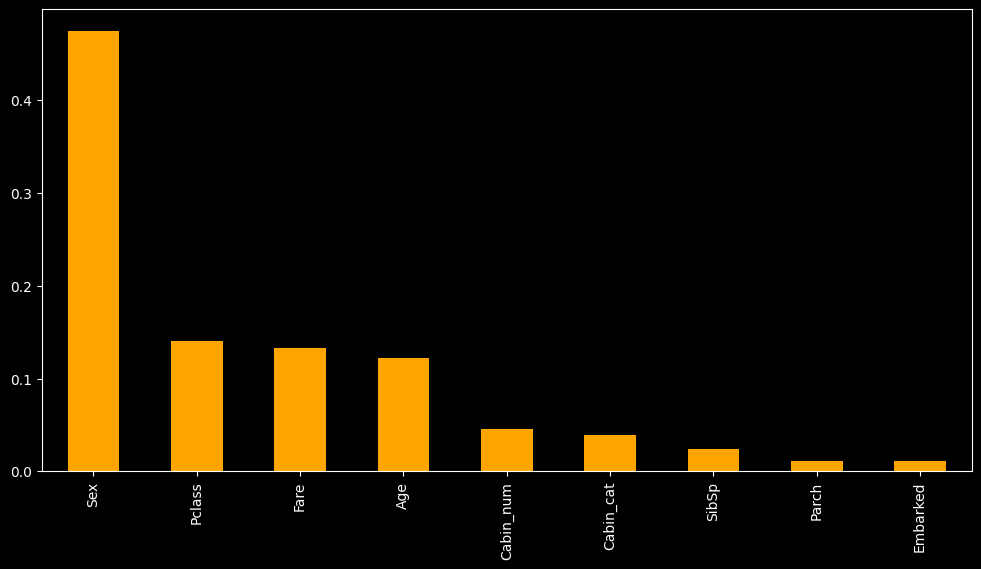

In [67]:
importance= pd.Series(titanic_pipe.named_steps["gbm"].feature_importances_,index=X_train.columns)
importance.sort_values(ascending=False,inplace=True)
importance.plot.bar(figsize=(12,6),color="orange")